In [21]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import numpy as np
import csv
import time
import os
from matplotlib import pyplot as plt
import sys
import matplotlib.gridspec as gridspec
from statsmodels.distributions.empirical_distribution import ECDF
sys.path.append("/Users/jenniferskerker/Documents/GradSchool/Research/Equity/Model/Santa_Cruz_WRM_updated/scripts/Plots")
import processing_functions as pf
import pandas as pd
import itertools
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
sys.path.append('../../../scripts/')
from Setup_SCWSM_Option_Analysis_CST import simSetup

# function to add desal plan, deploy, and ramp down lines to time series plot
def add_desal_labels(ax, y_min, y_max, df_time_tracker):
    lw = 1.8
    for i in range(len(df_time_tracker)):
        if i==0:
            ax.plot([df_time_tracker['plan_date'].iloc[i], df_time_tracker['plan_date'].iloc[i]], [y_min, y_max], color='darkgray', linestyle=':', linewidth=lw) # , label='plan date'
            ax.plot([df_time_tracker['deploy_date'].iloc[i], df_time_tracker['deploy_date'].iloc[i]], [y_min, y_max], color='gray', linestyle=':', linewidth=lw) # , label='deploy date'
            ax.plot([df_time_tracker['ramp_down_date'].iloc[i], df_time_tracker['ramp_down_date'].iloc[i]], [y_min, y_max], color='black', linestyle=':', linewidth=lw) # , label='ramp down date'
        else:
            ax.plot([df_time_tracker['plan_date'].iloc[i], df_time_tracker['plan_date'].iloc[i]], [y_min, y_max], color='darkgray', linestyle=':', linewidth=lw)
            ax.plot([df_time_tracker['deploy_date'].iloc[i], df_time_tracker['deploy_date'].iloc[i]], [y_min, y_max], color='gray', linestyle=':', linewidth=lw)
            ax.plot([df_time_tracker['ramp_down_date'].iloc[i], df_time_tracker['ramp_down_date'].iloc[i]], [y_min, y_max], color='black', linestyle=':', linewidth=lw)
        ax.axvspan(df_time_tracker['deploy_date'].iloc[i], df_time_tracker['ramp_down_date'].iloc[i], alpha=0.3, color='lightgray')
    ax.set_ylim(y_min, y_max)


def setup_climate_sims(real_All, dT_All, dP_All, dCV_All, demand_All):
    # get combinations of inputs
    combinations = list(itertools.product(real_All, dT_All, dP_All, dCV_All, demand_All))

    print('all scenario combinations: {}'.format(combinations))

    return combinations


# Purpose: post-process the results dataframe from Pywr
# Inputs:
#   df - dataframe from Pywr model instance
# Outputs:
#   df_processed - processed and cleaned up df
def post_process_results(df):
    # Take out the first empty row of the dataframe and rename the index
    df.columns = df.columns.get_level_values(0).tolist()
    df.index.name = 'Date'
    df.index = df.index.to_timestamp()
    # Sort the column by alphabetic order, and save the dataframe into a.csv file
    df_processed = df.reindex(sorted(df.columns), axis=1)
    return df_processed

# run simulation function- v2 where we input climate characteristics
def sim_model_run(decision_vars, filepath, real_All, dT_All, dP_All, dCV_All, demand_All, filepath_SA, name_add=''):
    # setup parameters for climate combinations
    #num_sims = 1
    #random_seed = 4
    # get climate combinations
    scenario = setup_climate_sims(real_All, dT_All, dP_All, dCV_All, demand_All)
    print(scenario)
    num_sims = len(scenario)

    # save climate scenario combinations
    headers = ['real', 'dT', 'dP', 'dCV', 'demand']
    # Save the list to a CSV file
    # with open(filepath + 'test_random_combinations_03Sept_NA.csv', 'w', newline='') as file:
    with open(filepath + 'climate_scenarios_21Nov2025.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        writer.writerows(scenario)

    # set up parameters for versions
    version_parent = 'SCWSM-Option_Analysis'
    version = 'SCWSM-SimOpt_Test'
    options = [None]

    # run one simulation at a time (I think I want to parallelize this)
    start_time = time.time()
    print('num sims: {}'.format(num_sims))
    for i in range(num_sims):
        print('simulation: {}'.format(str(i + 1)))
        print(scenario[i])
        # create an instance of the model
        modelSetup = simSetup(scenario[i][0], scenario[i][1], scenario[i][2], scenario[i][3], options, filepath_SA,
                              scenario[i][4], decision_vars)
        model = modelSetup.m  # convert from simSetup class to pywr model object

        # run the model
        model.run()

        # post-processing
        # results dataframe
        df_results = post_process_results(model.to_dataframe())
        # cashflow df
        df_cashflow = model.parameters['cashflow_model'].df_cashflow
        # add total demands by tier to df_cashflow
        num_tiers = model.parameters['cashflow_model'].num_tiers
        for j in range(num_tiers):
            print('tier: {}'.format(j))
            df_cashflow['demand_t{}'.format(j + 1)] = model.parameters['previous_time_step_demand'].arr_demand_by_tier[
                                                      :, j]

        print('after running tiers')
        # df time tracker
        df_time_tracker = model.parameters['cashflow_model'].df_time_tracker
        df_rof = pd.DataFrame(model.parameters['planning_inf'].list_rof, columns=['year', 'rof'])

        # all household data
        arr_hh = model.parameters['santa_cruz_demand_MGD'].arr_hh_data

        # save results
        # dataframes to save- df_cashflow, df_rates, df_results,
        dataframes = [df_results, df_cashflow, df_time_tracker, df_rof]
        filenames = ['df_results_{}P{}T{}_dCV{}_real{}_demand{}.csv'.format(name_add, scenario[i][2], scenario[i][1],
                                                                            scenario[i][3], scenario[i][0],
                                                                            scenario[i][4]),
                     'df_cashflow_{}P{}T{}_dCV{}_real{}_demand{}.csv'.format(name_add, scenario[i][2], scenario[i][1],
                                                                             scenario[i][3], scenario[i][0],
                                                                             scenario[i][4]),
                     'df_time_tracker_{}P{}T{}_dCV{}_real{}_demand{}.csv'.format(name_add, scenario[i][2],
                                                                                 scenario[i][1], scenario[i][3],
                                                                                 scenario[i][0], scenario[i][4]),
                     'df_rof_{}P{}T{}_dCV{}_real{}_demand{}.csv'.format(name_add, scenario[i][2], scenario[i][1], scenario[i][3], scenario[i][0], scenario[i][4])]
        print(filenames)
        # Iterate and save each DataFrame as a CSV
        for df, filename in zip(dataframes, filenames):
            df.to_csv(filepath + filename, index=True)

        filename = 'arr_hh_data_{}P{}T{}_dCV{}_real{}_demand{}.npy'.format(name_add, scenario[i][2], scenario[i][1],
                                                                           scenario[i][3], scenario[i][0],
                                                                           scenario[i][4])
        np.save(filepath + filename, arr_hh)

        print('saved data')

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Model ran in {elapsed_time} seconds')
    return model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# run simulation and save rof as timeseries
real_All = [3574]
dT_All = [5]
dP_All = [100]
dCV_All = [1.2]
demand_All = ['Baseline']

# policy: 1. desal, 2. dpr, 3. mcasr, 4. transfer soq, 5. transfer sv
decision_vars = [0.654, 0.4, 0.5, 0.3, 0.1, 0.2]
filepath = '../results/SCWSM-Option_Analysis/SA_test_Fall2025/'

filepath_SA = None 
name_add = 'rof_' 

# run model
os.chdir("./Santa_Cruz_WRM_updated/scripts/")
print(os.getcwd())
sim_model_run(decision_vars, filepath, real_All, dT_All, dP_All, dCV_All, demand_All, filepath_SA, name_add)

/Users/jenniferskerker/Documents/GradSchool/Research/Equity/Model/Santa_Cruz_WRM_updated/scripts
all scenario combinations: [(3574, 5, 100, 1.2, 'Baseline')]
[(3574, 5, 100, 1.2, 'Baseline')]
num sims: 1
simulation: 1
(3574, 5, 100, 1.2, 'Baseline')
do we make it here? line 73
hostname test:  Mac.attlocal.net
rank order:  [4 5 3 1 2]
about to start importing file_SA parameters
/Users/jenniferskerker/Documents/GradSchool/Research/Equity/Model/Santa_Cruz_WRM_updated/scripts
DEBUG - incoming data: {'parameters': ['order_TRANSFER_SOQUEL', 'order_TRANSFER_SCOTTS_VALLEY', 'order_DESALT_4MGD'], 'filename': 'inf_planning_assumptions.json'}
filename:  inf_planning_assumptions.json
i dont think we make it here
initialize householdDemand class instance
Loading HH data...
Loading DCC coefficients...
DCC coefficients: {'beta0': 0.51578855, 'betaPAl': -0.246029673, 'betaTax': 0.058392257, 'betaMA': 0.00019733, 'betaBath': 0.070615973, 'betaBathSq': -0.005088658, 'betaPool': 0.212250996, 'betaAET': -

/Users/jenniferskerker/anaconda3/envs/my_x86_env/lib/python3.12/site-packages/pywr/dataframe_tools.py:129: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  new_df = new_df.resample(target_index.freq).agg(resample_func)
/Users/jenniferskerker/anaconda3/envs/my_x86_env/lib/python3.12/site-packages/pywr/dataframe_tools.py:142: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  new_df = df.resample(target_single_tick).ffill()


2020-10-01 00:00:00
2020-11-01 00:00:00
2020-12-01 00:00:00
2021-01-01 00:00:00
2021-02-01 00:00:00
2021-03-01 00:00:00
2021-04-01 00:00:00
2021-05-01 00:00:00
2021-06-01 00:00:00
2021-07-01 00:00:00
2021-08-01 00:00:00
2021-09-01 00:00:00
2021-10-01 00:00:00
ll volume: 2334 MG (closest value: 2288), annual demands: 2778 MG, inf options set(), rof threshold: 0.654, rof value: 0.2030612244897959
2021-11-01 00:00:00
2021-12-01 00:00:00
2022-01-01 00:00:00
2022-02-01 00:00:00
2022-03-01 00:00:00
2022-04-01 00:00:00
2022-05-01 00:00:00
2022-06-01 00:00:00
2022-07-01 00:00:00
2022-08-01 00:00:00
2022-09-01 00:00:00
2022-10-01 00:00:00
ll volume: 2760 MG (closest value: 2717), annual demands: 2804 MG, inf options set(), rof threshold: 0.654, rof value: 0.15612244897959185
2022-11-01 00:00:00
2022-12-01 00:00:00
2023-01-01 00:00:00
2023-02-01 00:00:00
2023-03-01 00:00:00
2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
202

In [94]:
# import data for one simulation
# import cashflow data
filepath = '../results/SCWSM-Option_Analysis/SA_test_Fall2025/'
real = real_All[0]
dT = dT_All[0]
dP = dP_All[0]
dCV = dCV_All[0]
demand = demand_All[0]
name_add = 'rof_'

# import results data
df_results = pd.read_csv(filepath + 'df_results_{}P{}T{}_dCV{}_real{}_demand{}.csv'.format(name_add, dP, dT, dCV, real, demand))
df_results['Date'] = pd.to_datetime(df_results['Date'])
df_results.set_index("Date", inplace=True)
df_results_annual = df_results.resample('YE').sum()

# df results water year- compile results by water year
df_results['water_year'] = df_results.index.year + (df_results.index.month >= 10)
df_wy = df_results.groupby("water_year").sum() # ['Urban_Demand_Prior_Rationing']
df_wy['Date'] = pd.to_datetime(df_wy.index.astype(str) + "-10-01")
df_wy.set_index("Date", inplace=True)

# import cashflow data
df_cashflow = pd.read_csv(filepath + 'df_cashflow_{}P{}T{}_dCV{}_real{}_demand{}.csv'.format(name_add, dP, dT, dCV, real, demand))
df_cashflow['Date'] = pd.to_datetime(df_cashflow['Date'])
df_cashflow.set_index("Date", inplace=True)
df_cashflow
#print(df_cashflow)
num_tiers = sum(col.startswith("demand_") for col in df_cashflow.columns)
# get annual aggregation
df_cashflow_annual = df_cashflow.resample("YE").mean()

# import time tracker data
df_time_tracker = pd.read_csv(filepath + 'df_time_tracker_{}P{}T{}_dCV{}_real{}_demand{}.csv'.format(name_add, dP, dT, dCV, real, demand))
df_time_tracker['plan_date'] = pd.to_datetime(df_time_tracker['plan_date'])
df_time_tracker['deploy_date'] = pd.to_datetime(df_time_tracker['deploy_date'])
df_time_tracker['ramp_down_date'] = pd.to_datetime(df_time_tracker['ramp_down_date'])
#print(df_time_tracker)

# import rof data
df_rof = pd.read_csv(filepath + 'df_rof_{}P{}T{}_dCV{}_real{}_demand{}.csv'.format(name_add, dP, dT, dCV, real, demand))
df_rof['Date'] = pd.to_datetime(df_rof['year'].astype(str) + '-10-01')
df_rof['Date'] = pd.to_datetime(df_rof['Date'])
df_rof.set_index("Date", inplace=True)

# import rof table for storage =  1287
arr_rof_st1287 = np.load('../data/rof_data/' + 'rof_table_st1287.npy')
arr_rof_st2145 = np.load('../data/rof_data/' + 'rof_table_st2145.npy')
print(arr_rof_st2145.shape)


(9, 26)


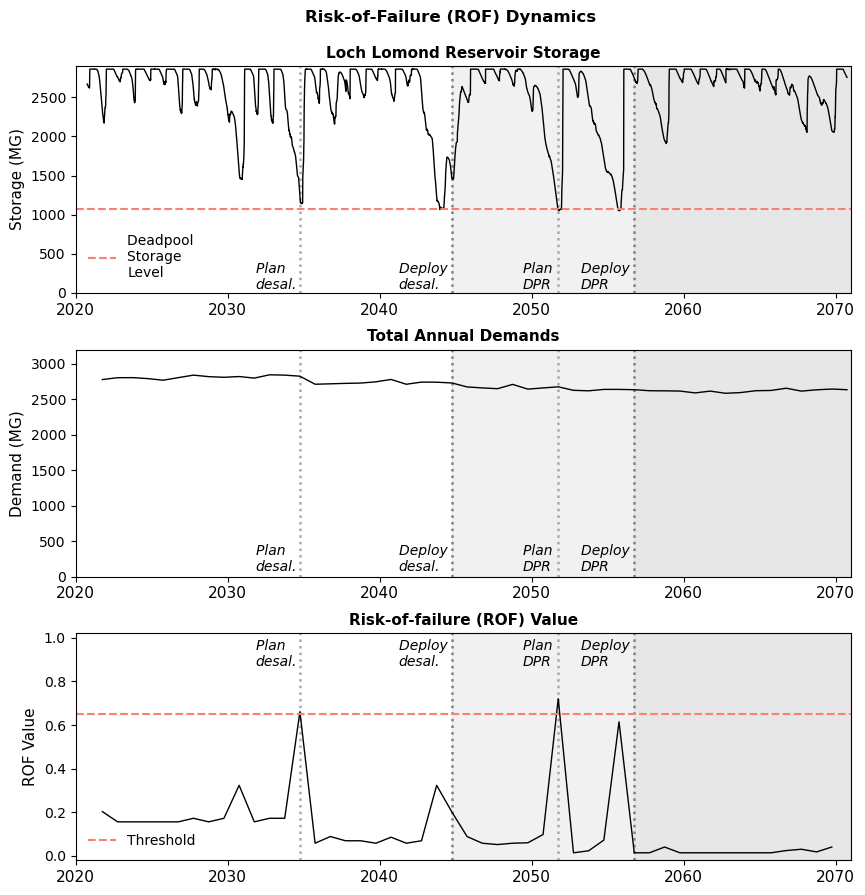

In [103]:
### create time series figure- v1  ###
start = pd.to_datetime("2020-01-01")
end   = pd.to_datetime("2070-12-31")
fig = plt.figure(figsize=(10, 14))
gs = gridspec.GridSpec(4, 2, hspace=0.25)

# set plotting parameters
alpha=0.4
lw = 1.0


# subplot 1: Reservoir storage
ax_top = fig.add_subplot(gs[0, :])
add_desal_labels(ax_top, 0, 2900, df_time_tracker)
ax_top.plot(df_results['LL_Reservoir_MG'], color='black', linewidth=lw)
ax_top.plot([start, end], [1070, 1070], color='salmon', linestyle='--', linewidth=lw*1.5, label='Deadpool \nStorage \nLevel')
ax_top.set_ylabel('Storage (MG)', fontsize=11)
ax_top.set_xlim(start, end)
ax_top.xaxis.set_major_locator(mdates.YearLocator(10)) # Tick every 10 years
ax_top.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Show only the year
ax_top.tick_params(axis='x', labelsize=11) # Optional: adjust label size / rotation
ax_top.legend(fontsize=10, loc='lower left', frameon=False)
ax_top.set_title('Loch Lomond Reservoir Storage', fontsize=11, fontweight='bold')

# add labels
y = 50
ft = 10
ax_top.text(pd.to_datetime("2031-11-01"), y, 'Plan \ndesal.', fontsize=ft, fontstyle='italic')
ax_top.text(pd.to_datetime("2041-04-01"), y, 'Deploy \ndesal.', fontsize=ft, fontstyle='italic')
ax_top.text(pd.to_datetime("2049-06-01"), y, 'Plan \nDPR', fontsize=ft, fontstyle='italic')
ax_top.text(pd.to_datetime("2053-04-01"), y, 'Deploy \nDPR', fontsize=ft, fontstyle='italic')
#ax_top.text(pd.to_datetime("2060-05-01"), y, 'Ramp down \ninfrastructure', fontsize=ft, fontstyle='italic')

# subplot 2: total demands
ax_1 = fig.add_subplot(gs[1, :])
add_desal_labels(ax_1, 0, 3200, df_time_tracker)
ax_1.plot(df_wy['Urban_Demand_Prior_Rationing'], color='black', linewidth=lw, label='Annual \nDemand')
ax_1.set_ylabel('Demand (MG)', fontsize=11)
ax_1.set_xlim(start, end)
ax_1.xaxis.set_major_locator(mdates.YearLocator(10)) # Tick every 10 years
ax_1.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Show only the year
ax_1.tick_params(axis='x', labelsize=11) # Optional: adjust label size / rotation
ax_1.set_title('Total Annual Demands', fontsize=11, fontweight='bold')

# add labels
y = 75
ft = 10
ax_1.text(pd.to_datetime("2031-11-01"), y, 'Plan \ndesal.', fontsize=ft, fontstyle='italic')
ax_1.text(pd.to_datetime("2041-04-01"), y, 'Deploy \ndesal.', fontsize=ft, fontstyle='italic')
ax_1.text(pd.to_datetime("2049-06-01"), y, 'Plan \nDPR', fontsize=ft, fontstyle='italic')
ax_1.text(pd.to_datetime("2053-04-01"), y, 'Deploy \nDPR', fontsize=ft, fontstyle='italic')

# subplot 3: ROF
ax_2 = fig.add_subplot(gs[2, :])
add_desal_labels(ax_2, -0.02, 1.02, df_time_tracker)
ax_2.plot(df_rof['rof'], color='black', linewidth=lw)
ax_2.plot([start, end], [0.65, 0.65], color='salmon', linestyle='--', linewidth=lw*1.5, label='Threshold')
ax_2.set_ylabel('ROF Value', fontsize=11)
ax_2.set_xlim(start, end)
ax_2.xaxis.set_major_locator(mdates.YearLocator(10)) # Tick every 10 years
ax_2.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Show only the year
ax_2.tick_params(axis='x', labelsize=11) # Optional: adjust label size / rotation
ax_2.legend(loc='lower left', fontsize=10, frameon=False)
ax_2.set_title('Risk-of-failure (ROF) Value', fontsize=11, fontweight='bold')

# add labels
y = 0.87
ft = 10
ax_2.text(pd.to_datetime("2031-11-01"), y, 'Plan \ndesal.', fontsize=ft, fontstyle='italic')
ax_2.text(pd.to_datetime("2041-04-01"), y, 'Deploy \ndesal.', fontsize=ft, fontstyle='italic')
ax_2.text(pd.to_datetime("2049-06-01"), y, 'Plan \nDPR', fontsize=ft, fontstyle='italic')
ax_2.text(pd.to_datetime("2053-04-01"), y, 'Deploy \nDPR', fontsize=ft, fontstyle='italic')

plt.suptitle('Risk-of-Failure (ROF) Dynamics', fontsize=12, fontweight='bold', y=0.92)
plt.savefig('../outputs/SA_Timeseries_ROF.png', bbox_inches='tight', dpi=300)
plt.show()

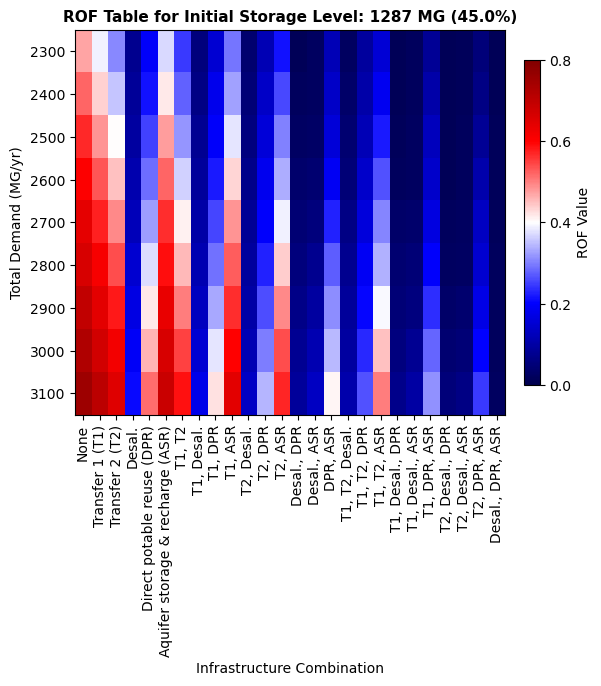

In [80]:
# heatmap plot for ROF lookup table
storage = 1287
x_labels = ['None', 'Transfer 1 (T1)', 'Transfer 2 (T2)', 'Desal.', 'Direct potable reuse (DPR)', 'Aquifer storage & recharge (ASR)', # 6
            'T1, T2', 'T1, Desal.', 'T1, DPR', 'T1, ASR', 'T2, Desal.', 'T2, DPR', 'T2, ASR', 'Desal., DPR', 'Desal., ASR', 'DPR, ASR', # 10
            'T1, T2, Desal.', 'T1, T2, DPR', 'T1, T2, ASR', 'T1, Desal., DPR', 'T1, Desal., ASR', 'T1, DPR, ASR', # 6
            'T2, Desal., DPR', 'T2, Desal., ASR', 'T2, DPR, ASR', 'Desal., DPR, ASR'] # 4
plt.figure(figsize=(6, 5))
im = plt.imshow(arr_rof_st1287, cmap='seismic', interpolation='nearest', vmin=0, vmax=0.8, aspect='auto')
# colorbar
cbar = plt.colorbar(im, fraction=0.035, pad=0.04)
cbar.set_label('ROF Value', fontsize=10)
cbar.ax.tick_params(labelsize=10)
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8])
# x axis: inf combinations
plt.xlabel('Infrastructure Combination', fontsize=10)
plt.xticks(ticks=np.arange(0, 26), labels=x_labels, rotation=90)

# y axis: demand levels
plt.ylabel('Total Demand (MG/yr)', fontsize=10)
y_labels = np.arange(2300, 3101, 100)
plt.yticks(ticks=np.arange(0, 9), labels=y_labels)

plt.title('ROF Table for Initial Storage Level: {} MG ({}%)'.format(round(storage), (storage / 2860 * 100)), fontsize=11, fontweight='bold')
plt.savefig('../outputs/ROF_Heatmap.png', bbox_inches='tight', dpi=300)
plt.show()